In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from salishsea_tools import geo_tools, viz_tools, evaltools as et, grid_tools
import gsw
import netCDF4 as nc
import datetime as dt
import cmocean
import pickle
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
obslat=50.117
obslon=-125.223
QU39lat=50.0306683333333
QU39lon=-125.099216666667
saveloc='/ocean/eolson/MEOPAR/obs/IzettCTD/tempfig'

In [3]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])
    e3t_0=np.copy(mesh.variables['e3t_0'][0,:,:,:])
    print(mesh.variables.keys())

dict_keys(['nav_lon', 'nav_lat', 'nav_lev', 'time_counter', 'tmask', 'umask', 'vmask', 'fmask', 'tmaskutil', 'umaskutil', 'vmaskutil', 'fmaskutil', 'glamt', 'glamu', 'glamv', 'glamf', 'gphit', 'gphiu', 'gphiv', 'gphif', 'e1t', 'e1u', 'e1v', 'e1f', 'e2t', 'e2u', 'e2v', 'e2f', 'ff', 'mbathy', 'misf', 'isfdraft', 'e3t_0', 'e3u_0', 'e3v_0', 'e3w_0', 'gdept_0', 'gdepu', 'gdepv', 'gdepw_0', 'gdept_1d', 'gdepw_1d', 'e3t_1d', 'e3w_1d'])


depth is 15 grid points at site or roughly 15.1 m


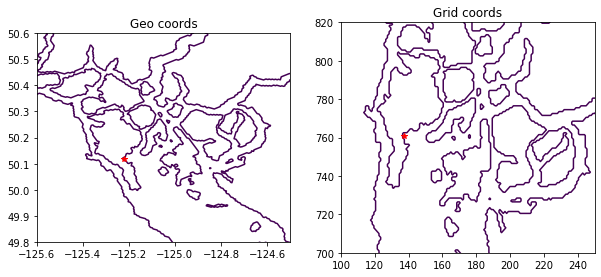

In [4]:
j,i=geo_tools.find_closest_model_point(obslon,obslat,navlon,navlat)
j39,i39=geo_tools.find_closest_model_point(QU39lon,QU39lat,navlon,navlat)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].contour(navlon,navlat,tmask[0,:,:],(0.5,))
ax[0].plot(navlon[j,i],navlat[j,i],'r*')
ax[0].set_xlim(-125.6,-124.5)
ax[0].set_ylim(49.8,50.6)
viz_tools.set_aspect(ax[0],coords='map')
ax[0].set_title('Geo coords')
ax[1].contour(tmask[0,:,:],(.5,))
ax[1].plot(i,j,'r*')
ax[1].set_xlim(100,250)
ax[1].set_ylim(700,820)
viz_tools.set_aspect(ax[1],coords='grid')
ax[1].set_title('Grid coords')
ks=np.sum(tmask[:,j,i])
print('depth is {0} grid points at site or roughly {1:3.1f} m'.format(ks,np.sum(e3t_0[:ks,j,i])))

In [5]:
start=dt.datetime(2020,4,1)
end=dt.datetime(2020,8,1)
flist=et.index_model_files(start,end,
                           '/results2/SalishSea/nowcast-green.201905/',
                           nam_fmt='nowcast',flen=1,ftype='grid_T',tres=1)

In [6]:
flist

,paths,t_0,t_n
0,/results2/SalishSea/nowcast-green.201905/01apr...,2020-04-01,2020-04-02
1,/results2/SalishSea/nowcast-green.201905/02apr...,2020-04-02,2020-04-03
2,/results2/SalishSea/nowcast-green.201905/03apr...,2020-04-03,2020-04-04
3,/results2/SalishSea/nowcast-green.201905/04apr...,2020-04-04,2020-04-05
4,/results2/SalishSea/nowcast-green.201905/05apr...,2020-04-05,2020-04-06
...,...,...,...
117,/results2/SalishSea/nowcast-green.201905/27jul...,2020-07-27,2020-07-28
118,/results2/SalishSea/nowcast-green.201905/28jul...,2020-07-28,2020-07-29
119,/results2/SalishSea/nowcast-green.201905/29jul...,2020-07-29,2020-07-30
120,/results2/SalishSea/nowcast-green.201905/30jul...,2020-07-30,2020-07-31


In [7]:

flistp=et.index_model_files(start,end,
                           '/results2/SalishSea/nowcast-green.201905/',
                           nam_fmt='nowcast',flen=1,ftype='ptrc_T',tres=1)

In [8]:

flistc=et.index_model_files(start,end,
                           '/results2/SalishSea/nowcast-green.201905/',
                           nam_fmt='nowcast',flen=1,ftype='carp_T',tres=1)

In [11]:
flistc.loc[flistc.t_0==dt.datetime(2020,7,10)]

,paths,t_0,t_n
100,/results2/SalishSea/nowcast-green.201905/10jul...,2020-07-10,2020-07-11


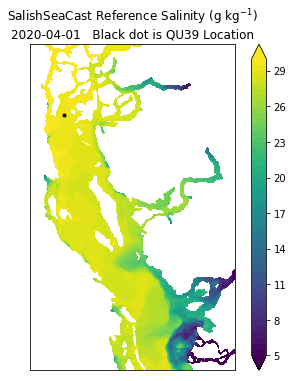

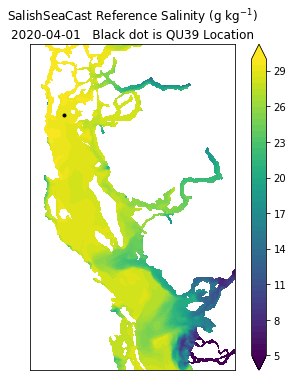

In [8]:
iw=100; ie=370
js=400; jn=830
iii=0
for ind,row in flist.head(1).iterrows():
    f=nc.Dataset(row['paths'])
    date=row['t_0']
    for hr in range(0,24,2):
        if iii>1:
            plt.close(fig)
        fig,ax=plt.subplots(1,1,figsize=(6,6))
        m=ax.contourf(np.ma.masked_where(tmask[0,js:jn,iw:ie]==0,
                                       f.variables['vosaline'][hr,0,js:jn,iw:ie]),
                    np.arange(5,30.5,.5),vmin=5,vmax=30,extend='both')
        ax.set_aspect(1)
        fig.colorbar(m,ax=ax)
        ax.set_title('SalishSeaCast Reference Salinity (g kg$^{-1}$)\n'+\
                     date.strftime('%Y-%m-%d')+'   Black dot is QU39 Location')
        ax.plot(i39-iw,j39-js,'k.')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        fig.savefig(saveloc+'/sal'+str(iii).zfill(4)+'.png',dpi=100)
        iii=iii+1
    f.close()

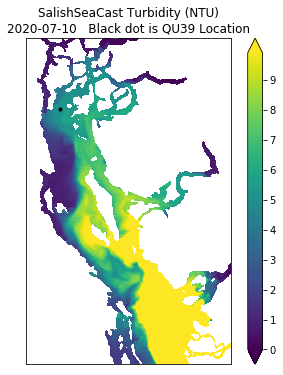

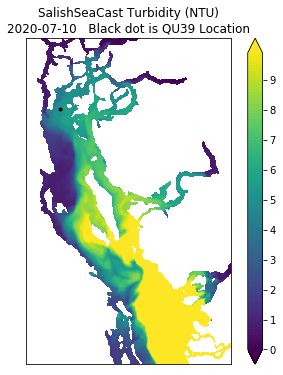

In [12]:
iw=100; ie=370
js=400; jn=830
iii=0
for ind,row in flistc.loc[flistc.t_0==dt.datetime(2020,7,10)].iterrows():
    f=nc.Dataset(row['paths'])
    date=row['t_0']
    for hr in range(0,2):#range(0,24,2):
        if iii>1:
            plt.close(fig)
        fig,ax=plt.subplots(1,1,figsize=(6,6))
        m=ax.contourf(np.ma.masked_where(tmask[0,js:jn,iw:ie]==0,
                                       f.variables['Fraser_tracer'][hr,0,js:jn,iw:ie]),
                    np.arange(0,10,.1),vmin=0,vmax=10,extend='both')
        ax.set_aspect(1)
        fig.colorbar(m,ax=ax)
        ax.set_title('SalishSeaCast Turbidity (NTU)\n'+\
                     date.strftime('%Y-%m-%d')+'   Black dot is QU39 Location')
        ax.plot(i39-iw,j39-js,'k.')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        fig.savefig(saveloc+'/sal'+str(iii).zfill(4)+'.png',dpi=100)
        iii=iii+1
    f.close()

In [13]:
ftest=nc.Dataset('/results/forcing/rivers/river_turb/riverTurbDaily2_y2020m07d10.nc')

In [15]:
ftest.variables['turb']

<class 'netCDF4._netCDF4.Variable'>
float64 turb(time_counter, y, x)
unlimited dimensions: time_counter
current shape = (1, 898, 398)
filling on, default _FillValue of 9.969209968386869e+36 used

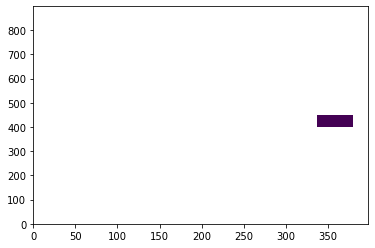

In [19]:
plt.pcolormesh(np.ma.masked_where(ftest.variables['turb'][0,:,:]==-999.99,
                                 ftest.variables['turb'][0,:,:]))

In [24]:
ftest2=nc.Dataset(flistc.loc[flistc.t_0==dt.datetime(2020,7,10)]['paths'].values[0])

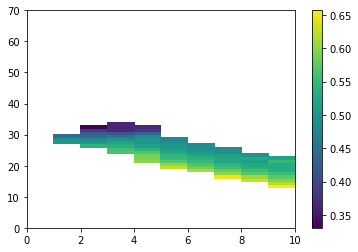

In [29]:
plt.pcolormesh(np.ma.masked_where(tmask[0,660:730,331:344]==0,ftest2.variables['Fraser_tracer'][0,0,660:730,331:344]))
plt.colorbar()

In [7]:
baseDirWind='/results/forcing/atmospheric/GEM2.5/operational/'
flistWind=et.index_model_files(start,end,baseDirWind,'wind',1,'None',1)
windWeights='/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/weights-gem2.5-ops_201702.nc'

In [8]:
mapCol=(0.67, 0.8, 0.64) # rgb
cm1=cmocean.cm.ice
cm1.set_bad(mapCol)

In [30]:
ftest3=nc.Dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/rivers-climatology/bio/R201906_bioConst.nc')

In [35]:
np.unique(ftest3.variables['zoo'][0,:,:])

masked_array(data=[0.001],
             mask=False,
       fill_value=1e+20)

In [ ]:
iw=100; ie=370
js=400; jn=830
iii=0
for ind,row in flist.iterrows():
    f=nc.Dataset(row['paths'])
    date=row['t_0']
    for hr in range(0,24,2):
        if iii>1:
            plt.close(fig)
        fig,ax=plt.subplots(1,2,figsize=(12,7))
        m=ax[0].contourf(np.ma.masked_where(tmask[0,js:jn,iw:ie]==0,
                                       f.variables['vosaline'][hr,0,js:jn,iw:ie]),
                    np.arange(5,30.5,.5),vmin=5,vmax=30,extend='both')
        ax[0].set_aspect(1)
        fig.colorbar(m,ax=ax[0])
        ax[0].set_title('SalishSeaCast Reference Salinity (g kg$^{-1}$)\n'+\
                     date.strftime('%Y-%m-%d')+'   Black dot is QU39 Location')
        ax[0].plot(i39-iw,j39-js,'k.')
        ax[0].xaxis.set_ticks([])
        ax[0].yaxis.set_ticks([])
        
        mat,ns=grid_tools.build_matrix(windWeights,
                                       flistWind.loc[ind,['paths']].values[0])
        uwnd=grid_tools.use_matrix(flistWind.loc[ind,['paths']].values[0],
                                   mat,ns,'u_wind',hr)
        vwnd=grid_tools.use_matrix(flistWind.loc[ind,['paths']].values[0],
                                   mat,ns,'v_wind',hr)
        ugrd,vgrd=viz_tools.rotate_vel(uwnd,vwnd,origin='map')
        clim=(0,15)
        subW=15
        meshWind=ax[1].contourf(np.ma.masked_where(tmask[0,js:jn,iw:ie]==0,
                    np.sqrt(ugrd[js:jn,iw:ie]**2+vgrd[js:jn,iw:ie]**2)),
                    np.linspace(clim[0],clim[1],200),vmin=clim[0],vmax=clim[1],
                                   cmap=cm1,extend='both')
        cb=fig.colorbar(meshWind,ax=ax[1],ticks=np.linspace(clim[0],clim[1],6))
        sh=np.shape(tmask[0,js:jn,iw:ie])
        shxW,shyW=np.meshgrid(np.arange(0,sh[1],subW),np.arange(0,sh[0],subW))
        Qw = ax[1].quiver(shxW,shyW,ugrd[js:jn:subW, iw:ie:subW], vgrd[js:jn:subW, iw:ie:subW],
                       pivot='mid', units='inches',width=.02)
        ax[1].set_title('Wind Velocity\n(m/s)')
        ax[1].xaxis.set_ticks([])
        ax[1].yaxis.set_ticks([])
        
        fig.savefig(saveloc+'/sal'+str(iii).zfill(4)+'.png',dpi=200)
        iii=iii+1
    f.close()